# Neural Agent Memory Analysis

This notebook analyzes the training memory of a neural agent to understand its performance and behavior over time. It loads the agent's memory, calculates win rates, and visualizes action distributions.

In [ ]:
# Import necessary libraries
from pathlib import Path
import pickle
import numpy as np
from typing import List, Tuple

# Assuming src is in the python path or adjust sys.path if needed
import sys
sys.path.append('../') # Example if running from notebooks dir

from src.engine.actions import Action
from src.analysis.memory_analyzer import analyze_win_loss_and_steps, calculate_win_rate_over_time, analyze_and_plot_win_rates_by_starting_position

In [2]:
def load_memory(memory_file_path: Path) -> List[List[Tuple]]:
    """Loads the agent's memory from a pickle file."""
    try:
        with open(memory_file_path, 'rb') as f:
            memory = pickle.load(f)
        print(f"Successfully loaded {len(memory)} episodes from {memory_file_path}.")
        # Use print instead of log in notebooks for direct output
        # log(f"Successfully loaded {len(memory)} episodes from {memory_file_path}.")
        return memory
    except FileNotFoundError:
        print(f"Error: Memory file not found at {memory_file_path}")
        # log(f"Error: Memory file not found at {memory_file_path}")
        return []
    except Exception as e:
        print(f"Error loading memory from {memory_file_path}: {e}")
        # log(f"Error loading memory from {memory_file_path}: {e}")
        return []

# Get the user's home directory
home_dir = Path.home()

# Construct the path to the Downloads folder (or wherever your memory file is)
downloads_dir = home_dir / "Downloads"
# Define the path to the memory file
memory_file = downloads_dir / "memory.pkl"

# Load the memory
agent_memory = load_memory(memory_file)

Successfully loaded 550 episodes from C:\Users\timmie\Downloads\memory.pkl.


In [3]:
from collections import Counter

# Initialize counters
action_type_counts = Counter()
card_action_counts = Counter() # Counts actions involving specific cards
card_name_to_obj = {} # Map card names to objects for easier access

total_actions_processed = 0
invalid_action_formats = 0

print("Starting action analysis...")

# Check if agent_memory is loaded and not empty
if agent_memory:
    num_episodes = len(agent_memory)
    print(f"Analyzing {num_episodes} episodes...")

    for i, episode in enumerate(agent_memory):
        if not episode:
            # print(f"Warning: Episode {i} is empty.") # Optional: for debugging
            continue

        for j, transition in enumerate(episode):
            # Ensure transition has the expected structure
            if len(transition) != 5:
                 # print(f"Warning: Invalid transition format in episode {i}, step {j}") # Optional
                 continue

            state, action, reward, next_state, done = transition
            total_actions_processed += 1

            # Check if action is an instance of the Action class
            if isinstance(action, Action):
                # Count by action type (using the enum member itself as key)
                action_type_counts[action.type] += 1

                if action.card is not None:
                    # Count actions involving specific cards
                    card_action_counts[(action.type, action.card.name)] += 1
                    card_name_to_obj[action.card.name] = action.card  # Store card object for later use
            else:
                # Count actions that are not Action objects
                action_type_counts["Unknown/Invalid Action Format"] += 1
                invalid_action_formats += 1
                # print(f"Warning: Non-Action object found in episode {i}, step {j}: {type(action)}") # Optional

    # --- Generate Report ---
    print("\n--- Action Analysis Report ---")
    print(f"Total actions processed across {num_episodes} episodes: {total_actions_processed}")
    if invalid_action_formats > 0:
        print(f"Warning: Encountered {invalid_action_formats} actions with unexpected format.")

    print("\n1. Overall Action Type Distribution:")
    if action_type_counts:
        total_type_actions = sum(action_type_counts.values())
        # Sort by count descending
        sorted_types = sorted(action_type_counts.items(), key=lambda item: item[1], reverse=True)
        for action_type, count in sorted_types:
            percentage = (count / total_type_actions) * 100 if total_type_actions > 0 else 0
            # Get enum name if possible, otherwise use string representation
            type_name = action_type.name if hasattr(action_type, 'name') else str(action_type)
            print(f"- {type_name}: {count} ({percentage:.2f}%)")
    else:
        print("No action type data found.")

    print("\n2. Detailed Card Action Distribution:")
    if card_action_counts:
        total_card_actions = sum(card_action_counts.values())
        print(f"Total actions involving specific cards: {total_card_actions}\n")

        # Group actions by ActionType
        grouped_actions = {}
        for (action_type, card_name), count in card_action_counts.items():
            if action_type not in grouped_actions:
                grouped_actions[action_type] = []
            grouped_actions[action_type].append({'card_name': card_name, 'count': count})

        # Sort the groups by ActionType name for consistent output order
        # You could define a custom order here if needed, similar to the previous suggestion
        sorted_action_types = sorted(grouped_actions.keys(), key=lambda at: at.name)

        # Prepare data for potential DataFrame display (optional, kept for context)
        report_data = []

        # Iterate through sorted action types and print sorted card counts within each type
        for action_type in sorted_action_types:
            type_name = action_type.name if hasattr(action_type, 'name') else str(action_type)
            print(f"--- {type_name} ---")

            # Sort cards within this action type by count (descending)
            sorted_cards_in_group = sorted(grouped_actions[action_type], key=lambda item: item['count'], reverse=True)

            this_card_actions = sum(card_info['count'] for card_info in sorted_cards_in_group)

            for card_info in sorted_cards_in_group:
                card_name = card_info['card_name']
                count = card_info['count']
                percentage = (count / this_card_actions) * 100 if this_card_actions > 0 else 0
                # Get the card object string representation
                card_str = str(card_name_to_obj.get(card_name, card_name)) # Use card_name as fallback
                print(f"Count: {count} ({percentage:.2f}%) - Card: '{card_str}'")
                report_data.append({'Action Type': type_name, 'Card Name': card_name, 'Count': count, 'Percentage': percentage})
            print("") # Add a newline between action types


    else:
        print("No actions involving specific cards found.")

    print("\n-----------------------------")

else:
    print("Agent memory is empty or not loaded. Cannot generate action report.")

Starting action analysis...
Analyzing 550 episodes...

--- Action Analysis Report ---
Total actions processed across 550 episodes: 73184

1. Overall Action Type Distribution:
- PLAY_CARD: 45342 (61.96%)
- ATTACK_PLAYER: 9068 (12.39%)
- END_TURN: 8942 (12.22%)
- BUY_CARD: 6737 (9.21%)
- APPLY_EFFECT: 1302 (1.78%)
- SCRAP_CARD: 694 (0.95%)
- DISCARD_CARDS: 496 (0.68%)
- ATTACK_BASE: 414 (0.57%)
- SKIP_DECISION: 168 (0.23%)
- DESTROY_BASE: 21 (0.03%)

2. Detailed Card Action Distribution:
Total actions involving specific cards: 52079

--- BUY_CARD ---
Count: 340 (5.05%) - Card: 'Core Set Cutter (2 cost) | Faction: Trade Federation | Type: ship | Effects: Trade: 2, Trade Federation Ally: Combat: 4'
Count: 319 (4.74%) - Card: 'Core Set Blob Wheel (3 cost) | Faction: Blob | Defense: 5 | Type: base | Effects: Combat: 1, (Scrap required): Trade: 3'
Count: 308 (4.57%) - Card: 'Core Set Blob Fighter (1 cost) | Faction: Blob | Type: ship | Effects: Combat: 3, Blob Ally: Draw: 1'
Count: 295 (4.38%

Analyzed 550 completed episodes for outcomes and steps.
First player episodes: 273, Second player episodes: 277
Total actions analyzed: 73184
Analyzed 550 completed episodes for outcomes and steps.
First player episodes: 273, Second player episodes: 277
Total actions analyzed: 73184
Overall win rate (latest 100 episodes): 54.36% over 550 episodes
Win rate when agent starts first (latest chunk): 55.68% over 273 episodes
Win rate when agent starts second (latest chunk): 53.07% over 277 episodes


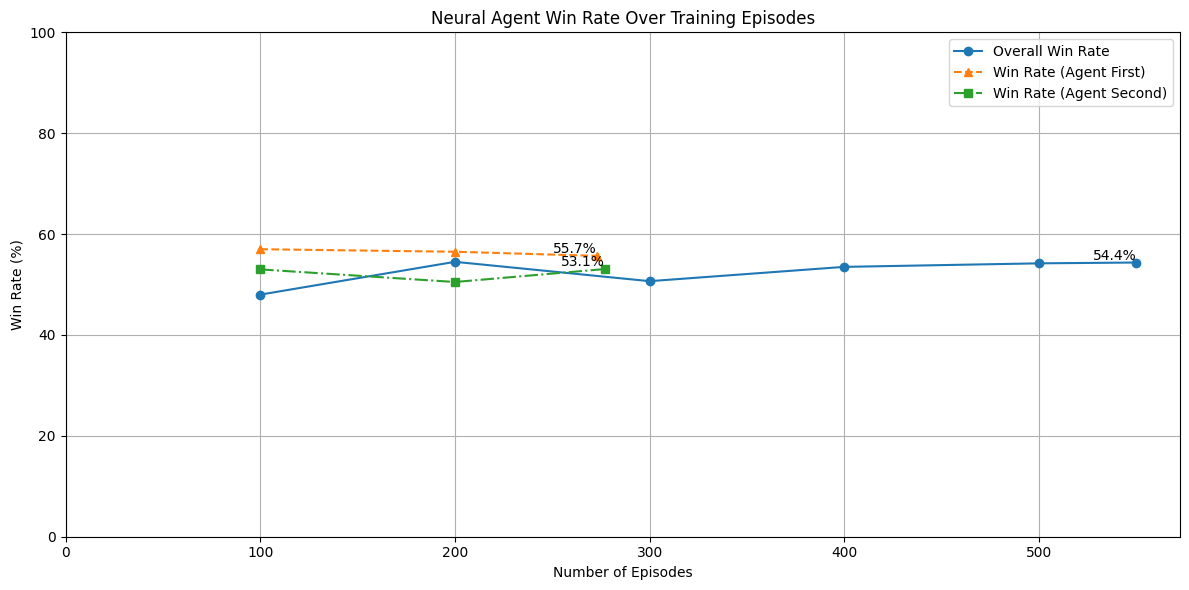

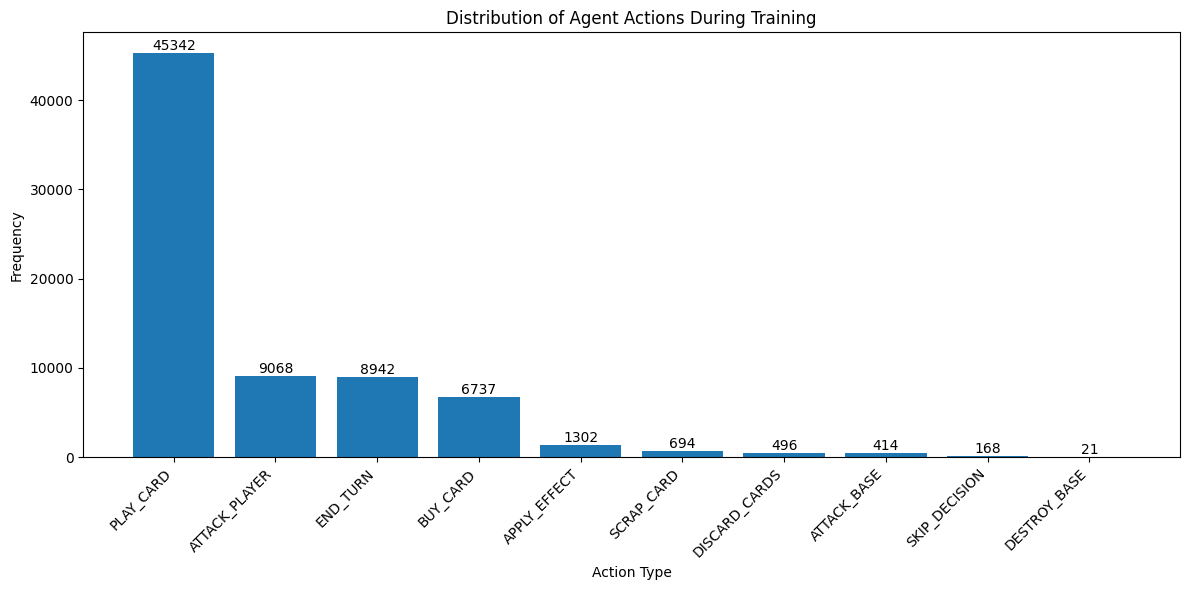


--- Analysis Summary ---
Total valid episodes analyzed: 550
Overall Win Rate: 54.36%
Average steps per episode: 133.06
Median steps per episode: 129.0
Min steps per episode: 83
Max steps per episode: 363

--- Action Distribution ---
Total actions taken across all episodes: 73184
- PLAY_CARD: 45342 (61.96%)
- ATTACK_PLAYER: 9068 (12.39%)
- END_TURN: 8942 (12.22%)
- BUY_CARD: 6737 (9.21%)
- APPLY_EFFECT: 1302 (1.78%)
- SCRAP_CARD: 694 (0.95%)
- DISCARD_CARDS: 496 (0.68%)
- ATTACK_BASE: 414 (0.57%)
- SKIP_DECISION: 168 (0.23%)
- DESTROY_BASE: 21 (0.03%)
------------------------


In [5]:
if agent_memory:
    # Analyze win/loss outcomes, steps per episode, and action counts
    episode_outcomes, first_player_outcomes, second_player_outcomes, episode_steps, action_distribution = analyze_win_loss_and_steps(agent_memory)

    if episode_outcomes:
        # Calculate win rate over time (e.g., in chunks of 100 episodes)
        chunk_size = 100
        chunks, rates = calculate_win_rate_over_time(episode_outcomes, chunk_size)

        # Plot the results
        analyze_and_plot_win_rates_by_starting_position(memory=agent_memory, chunk_size=chunk_size)

        # Print overall summary
        overall_win_rate = np.mean(episode_outcomes) * 100
        print(f"\n--- Analysis Summary ---")
        print(f"Total valid episodes analyzed: {len(episode_outcomes)}")
        print(f"Overall Win Rate: {overall_win_rate:.2f}%")

        # Calculate and print step statistics
        if episode_steps:
            avg_steps = np.mean(episode_steps)
            median_steps = np.median(episode_steps)
            min_steps = np.min(episode_steps)
            max_steps = np.max(episode_steps)
            print(f"Average steps per episode: {avg_steps:.2f}")
            print(f"Median steps per episode: {median_steps}")
            print(f"Min steps per episode: {min_steps}")
            print(f"Max steps per episode: {max_steps}")
        else:
            print("No step data available for completed episodes.")

        # Print action distribution summary
        print("\n--- Action Distribution ---")
        if action_distribution:
            total_actions = sum(action_distribution.values())
            print(f"Total actions taken across all episodes: {total_actions}")
            # Sort actions by count for display
            sorted_actions = sorted(action_distribution.items(), key=lambda item: item[1], reverse=True)
            for action_type, count in sorted_actions:
                percentage = (count / total_actions) * 100 if total_actions > 0 else 0
                # Use ActionType.name if available
                action_name = action_type.name if hasattr(action_type, 'name') else str(action_type)
                print(f"- {action_name}: {count} ({percentage:.2f}%)")
        else:
            print("No action data recorded.")
        print(f"------------------------")

    else:
        print("No valid episode outcomes found to calculate statistics.")
else:
    print("Could not load memory or memory is empty.")
